In [2]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

In [158]:
class Node():
    def __init__(self, features = None, threshold = None, left = None, right = None,*, value = None):
        self.features = features
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value
    
    def _is_leaf_node(self):
        return self.value is not None
    
class _Decision_Tree_():
    def __init__(self, min_sample_split = 3, max_depth = 200, n_features = None):
        self.min_sample_split = min_sample_split
        self.max_depth = max_depth
        self.n_features = n_features
        self.roots = None

    def fit(self, x,y):
        self.n_features = x.shape[1] if not self.n_features else min(x.shape[1], self.n_features)
        self.root = self._grow_tree_(x,y)
    
    def _grow_tree_(self,x,y,depth = 0):
        n_samples, n_feature = x.shape
        n_labels = len(np.unique(y))

        # stopping condition
        if (depth >= self.max_depth or n_labels == 1 or n_samples < self.min_sample_split):
            leaf_value = self.most_common_value(y)
            return Node(value = leaf_value)
        
        feats = np.random.choice(n_feature, self.n_features, replace=False)
        best_features, best_threshold = self._best_split_(x,y,feats)

        left_idxs, right_idxs = self._split_(x[:, best_features], best_threshold)
        left = self._grow_tree_(x[left_idxs,:], y[left_idxs], depth+1)
        right = self._grow_tree_(x[right_idxs,:], y[right_idxs], depth+1)

        return Node(best_features, best_threshold, left, right)

    def most_common_value(self,y):
        #y=np.ravel(y)
        counter = Counter(y)
        common_value = counter.most_common(1)[0][0]
        return common_value
    
    def _best_split_(self,x,y, n_feats):
        best_gain = -1
        split_idxs, split_threshold = None, None

        for idxs in n_feats:
            x_column = x[:,idxs]
            threshold = np.unique(x_column)

            for thr in threshold:
                gain = self._information_gain_(x_column,y,thr)

                if gain > best_gain:
                    best_gain = gain
                    split_idxs = idxs
                    split_threshold = thr
            
        return split_idxs, split_threshold

    def _information_gain_(self,x,y,thrs):
        parent_entropy = self._entropy_(y)

        left_idxs, right_idxs = self._split_(x,thrs)

        if len(left_idxs) == 0 or len(right_idxs) == 0 :
            return 0
        
        n = len(y)
        n_l, n_r = len(left_idxs), len(right_idxs)
        e_l, e_r = self._entropy_(y[left_idxs]), self._entropy_(y[right_idxs])

        child_entropy = (n_l/n)*e_l + (n_r/n)*e_r

        info = parent_entropy - child_entropy
        return info

    def _entropy_(self,y):
        #y = y.ravel()
        hist = np.bincount(y)
        ps = hist/len(y)
        ent = -np.sum([p*np.log(p) for p in ps if p>0])
        return ent
    
    def _split_(self, x,thrsh):
        left = np.argwhere(x <= thrsh).flatten()
        right = np.argwhere(x > thrsh).flatten()
        return left, right
    
    def predict(self,x):
        pred = self._traverse_tree_(x, self.root)
        return pred
    
    def _traverse_tree_(self, x, node):
        if node._is_leaf_node(): 
            return [1.0 if node.value == 0 else 0.0, 1.0 if node.value == 1 else 0.0]
        
        if x[node.features] <= node.threshold:
            return self._traverse_tree_(x,node.left)
        return self._traverse_tree_(x, node.right)


In [159]:
class Random_forest():
    def __init__(self, min_sample_split = 2, max_depth = 10, n_trees = 20, n_features = None):
        self.n_features = n_features
        self.min_sample_split = min_sample_split
        self.max_depth = max_depth
        self.n_trees =n_trees
        self.trees = []

    def fit(self,x,y):
        self.trees = []
        for _ in range(self.n_trees):
            tree = _Decision_Tree_(min_sample_split = self.min_sample_split, max_depth = self.max_depth, n_features = self.n_features)

            x_sample, y_sample = self.bootstrap(x,y)
            tree.fit(x_sample,y_sample)
            self.trees.append(tree)

    def bootstrap(self,x,y):
        n_samples = x.shape[0]
        idxs = np.random.choice(n_samples, n_samples, replace= True)
        return x[idxs], y[idxs]

    def predict(self,x):
        tree_probs = np.array([tree.predict(xi) for tree in self.trees for xi in x])
        tree_probs = tree_probs.reshape(len(self.trees), len(x),2)
        avg_predictions = np.mean(tree_probs, axis=0)
        return avg_predictions

    def most_common_value(self,y):
        counter = Counter(y)
        commo = counter.most_common(1)[0][0]
        return commo

In [84]:
import pandas as pd

df = pd.read_csv('diabetes.csv')
cols = df.columns

In [85]:
for col in cols:
    df[col] = (df[col] - df[col].min())/(df[col].max() - df[col].min())


In [86]:
for col in cols:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3-q1
    lower_bound = q1-iqr*1.5
    upper_bound = q3+iqr*1.5

    df[col] = df[col].apply(lambda x : lower_bound if x<lower_bound else upper_bound if x>upper_bound else x)

In [87]:
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0.352941,0.743719,0.590164,0.353535,0.000000,0.500745,0.234415,0.483333,1.0
1,0.058824,0.427136,0.540984,0.292929,0.000000,0.396423,0.116567,0.166667,0.0
2,0.470588,0.919598,0.524590,0.000000,0.000000,0.347243,0.253629,0.183333,1.0
3,0.058824,0.447236,0.540984,0.232323,0.111111,0.418778,0.038002,0.000000,0.0
4,0.000000,0.688442,0.327869,0.353535,0.198582,0.642325,0.479078,0.200000,1.0
...,...,...,...,...,...,...,...,...,...
763,0.588235,0.507538,0.622951,0.484848,0.212766,0.490313,0.039710,0.700000,0.0
764,0.117647,0.613065,0.573770,0.272727,0.000000,0.548435,0.111870,0.100000,0.0
765,0.294118,0.608040,0.590164,0.232323,0.132388,0.390462,0.071307,0.150000,0.0
766,0.058824,0.633166,0.491803,0.000000,0.000000,0.448584,0.115713,0.433333,1.0


In [100]:
df.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [88]:
x = df.iloc[:,:-1].values
y = df.iloc[:,-1:].values

In [91]:
y = y.astype(int)
y = y.flatten()
y

array([1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0,
       1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0,
       1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0,
       0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1,

In [160]:
from sklearn.model_selection import train_test_split
x_train,x_test, y_train,y_test = train_test_split(x,y, test_size = 0.2, random_state =123)

clf = Random_forest()
clf.fit(x_train,y_train)
y_pred_ = clf.predict(x_test)
y_pred = np.argmax(y_pred_, axis=1)

def recall_(y_pred, y_test):
        TP = np.sum((y_pred ==1 ) & (y_test == 1))
        FN = np.sum((y_pred == 0) & (y_test == 1))
        return (TP/(TP + FN) if (TP + FN) != 0 else 0)
print('calculated recal = ', recall_(y_pred, y_test))

def specificivity_(y_pred, y_test):
    TN = np.sum((y_pred ==0 ) & (y_test == 0))
    FP = np.sum((y_pred == 1) & (y_test == 0))
    return (TN/(TN + FP) if (TN + FP) != 0 else 0)
print('calculated specificivity_ = ', specificivity_(y_pred, y_test))

def precision_(y_pred, y_test):
    TP = np.sum((y_pred == 1 ) & (y_test == 1))
    FP = np.sum((y_pred == 1) & (y_test == 0))
    return (TP/(TP + FP) if (TP + FP) != 0 else 0)
print('calculated precision_ = ', precision_(y_pred, y_test))

def f1_score_(y_pred, y_test):
    precision = precision_(y_pred, y_test)
    recall = recall_(y_pred, y_test)
    return ((2*precision*recall)/(precision+recall) if (precision+recall) != 0 else 0)
print('calculated f1 score = ', f1_score_(y_pred, y_test))

def accuracy_(y_pred, y_test):
    TP = np.sum((y_pred ==1 ) & (y_test == 1))
    TN = np.sum((y_pred ==0 ) & (y_test == 0))
    FP = np.sum((y_pred == 1) & (y_test == 0))
    FN = np.sum((y_pred == 0) & (y_test == 1))
    return (((TP+TN) / (TP+TN+FP+FN)) if (TP+TN+FP+FN) != 0 else 0)
print('calculated accuracy_ = ', accuracy_(y_pred, y_test))

from sklearn.metrics import log_loss
print('log loss is = ', log_loss(y_test,y_pred_[:,1]))

calculated recal =  0.7241379310344828
calculated specificivity_ =  0.8125
calculated precision_ =  0.7
calculated f1 score =  0.711864406779661
calculated accuracy_ =  0.7792207792207793
log loss is =  0.43269401533883517


### ROC AND AUC
#### AUC (Area Under Curve) : score that tells you how good it is at ranking positives higher than negatives. higher value is more prefered.
#### ROC (Receiver Operating Characteristic) : Shows trade off between recall and specificity. A perfect model will go to the top-left corner (high recall, low false positives).


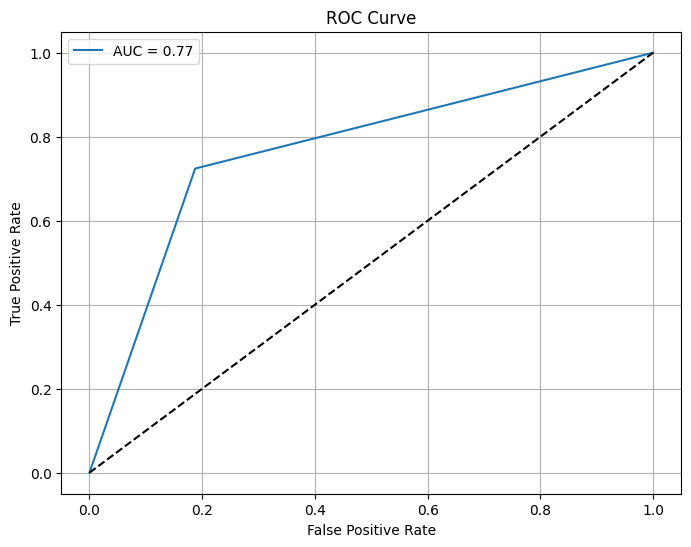

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

#fpr : false positive rate meaning how well my model oredicted patient to be diabetic even tho they are not
# tpr : true positive rate meaning how well my model predicted diabetic patient
fpr,tpr,threshold = roc_curve(y_test, y_pred)
# Plot it
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_pred):.2f}")
plt.plot([0, 1], [0, 1], 'k--')  # diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()